# **Utilisation du VGG-16 pré-entraîné (sur ImageNet)**

In [ ]:
from keras.applications.vgg16 import VGG16

model = VGG16() # Charger VGG16 implementé par Keras et déjà entraîné sur ImageNet (1000 classes)

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [ ]:
from google.colab import files
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input, decode_predictions

# Uploader une image depuis ton PC
uploaded = files.upload()   # tu choisis une image .jpg ou .png

# Récupérer le nom du fichier uploadé
image_path = list(uploaded.keys())[0]

# Charger et prétraiter l'image
img = load_img(image_path, target_size=(224, 224))  # redimensionner
img = img_to_array(img)  # convertir en tableau numpy
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # ajouter batch dimension
img = preprocess_input(img)  # prétraitement VGG16

print("Image prête pour la prediction de VGG16 :", image_path)


Saving cat.jpg to cat.jpg
Image prête pour la prediction de VGG16 : cat.jpg


In [ ]:
y = model.predict(img)  # Prédire la classe de l'image (parmi les 1000 classes d'ImageNet)

labels = decode_predictions(y, top=3)[0] # Décoder les prédictions (Top-3 classes: Afficher les 3 meilleures classes avec leur probabilité)

print("Résultats de prédiction :")
for (imagenet_id, label, score) in labels:
    print(f"{label}: {score*100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Résultats de prédiction :
tiger_cat: 43.02%
Egyptian_cat: 29.99%
tabby: 15.05%


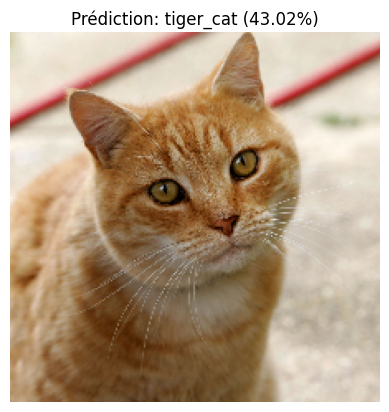

In [ ]:
import matplotlib.pyplot as plt

# Afficher l'image avec la meilleure prédiction en titre
best_label, best_score = labels[0][1], labels[0][2]
plt.imshow(load_img(image_path, target_size=(224, 224)))
plt.title(f"Prédiction: {best_label} ({best_score*100:.2f}%)")
plt.axis("off")
plt.show()

# **Transfert learning**

In [ ]:
from keras.layers import Dense, Flatten
from keras.models import Model
from keras import optimizers

# Charger VGG-16 sans la partie classification d’origine
model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3)) # include_top=False → on supprime les 3 couches fully-connected de VGG-16, car elles étaient prévues pour 1000 classes (ImageNet)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# On récupère la sortie du réseau VGG-16 (une matrice 3D)
x = model.output

# On convertit cette matrice en vecteur 1D pour la fully-connected
x = Flatten()(x)

# On ajoute notre nouvelle couche fully-connected (ex : 10 classes)
predictions = Dense(10, activation="softmax")(x)


In [ ]:
# Construire le nouveau modèle (il passe par toutes les couches convolutionnelles de VGG, puis finit par notre nouveau classifieur)
new_model = Model(inputs=model.input, outputs=predictions)


### **Choisir la stratégie de Transfer Learning**




In [ ]:
# Stratégie 1 : Fine-tuning total
# On entraîne toutes les couches (y compris celles de VGG)

for layer in model.layers:
    layer.trainable = True

In [ ]:
# Stratégie 2 : Extraction de features
# On gèle toutes les couches de VGG (on ne les réentraîne pas), seul notre classifieur est entraîné

for layer in model.layers:
    layer.trainable = False

In [ ]:
# Stratégie 3 : Fine-tuning partiel
# On gèle seulement les couches basses et on réentraîne les couches hautes + notre classifieur

# On gèle les 10 premières couches
for layer in model.layers[:10]:
    layer.trainable = False

# On laisse les autres entraînables
for layer in model.layers[10:]:
    layer.trainable = True


### **Test avec CIFAR-10 (un dataset intégré à Keras)**


In [ ]:
# ---------------------------
# TRANSFER LEARNING - VGG16
# Comparaison des 3 stratégies
# Dataset : CIFAR-10
# ---------------------------

import numpy as np
import cv2
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten, Dropout
from keras import Model, optimizers
import matplotlib.pyplot as plt

# ---------------------------
# Étape 1 : Charger CIFAR-10
# ---------------------------
(X_train, y_train), (X_val, y_val) = cifar10.load_data()

# Redimensionner en 224x224 pour VGG16
X_train_resized = np.array([cv2.resize(img, (224, 224)) for img in X_train])
X_val_resized   = np.array([cv2.resize(img, (224, 224)) for img in X_val])

# Normalisation entre 0 et 1
X_train_resized = X_train_resized.astype('float32') / 255.0
X_val_resized   = X_val_resized.astype('float32') / 255.0

# Encodage one-hot
y_train_cat = to_categorical(y_train, 10)
y_val_cat   = to_categorical(y_val, 10)

# ---------------------------
# Étape 2 : Fonction modèle
# ---------------------------
def build_model(strategy="feature_extraction", trainable_layers=4):
    """
    strategy: "feature_extraction", "fine_tuning_total", "fine_tuning_partiel"
    trainable_layers: nb de couches à dégeler pour fine-tuning partiel
    """
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))

    # Geler ou dégeler en fonction de la stratégie
    if strategy == "feature_extraction":
        for layer in base_model.layers:
            layer.trainable = False
    elif strategy == "fine_tuning_total":
        for layer in base_model.layers:
            layer.trainable = True
    elif strategy == "fine_tuning_partiel":
        for layer in base_model.layers[:-trainable_layers]:
            layer.trainable = False
        for layer in base_model.layers[-trainable_layers:]:
            layer.trainable = True

    # Ajouter classifieur personnalisé
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    predictions = Dense(10, activation="softmax")(x)

    new_model = Model(inputs=base_model.input, outputs=predictions)

    # Compiler
    new_model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizers.SGD(learning_rate=0.0001, momentum=0.9),
        metrics=["accuracy"]
    )

    return new_model

# ---------------------------
# Étape 3 : Entraîner et comparer
# ---------------------------
epochs = 5   # peux etre augmenté (ex: 20)
batch_size = 64

strategies = ["feature_extraction", "fine_tuning_total", "fine_tuning_partiel"]
history_dict = {}

for strat in strategies:
    print(f"\n Entraînement stratégie : {strat}")
    model = build_model(strategy=strat, trainable_layers=6)  # pour partiel, dernières 6 couches
    history = model.fit(
        X_train_resized, y_train_cat,
        validation_data=(X_val_resized, y_val_cat),
        epochs=epochs,
        batch_size=batch_size,
        verbose=2
    )
    history_dict[strat] = history

# ---------------------------
# Étape 4 : Visualisation résultats
# ---------------------------
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
for strat in strategies:
    plt.plot(history_dict[strat].history['val_accuracy'], label=strat)
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
for strat in strategies:
    plt.plot(history_dict[strat].history['val_loss'], label=strat)
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()
